In [37]:

import os
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True, parents=True)
CSV_PATH = DATA_DIR / "Food_Delivery_Time_Prediction-1.csv"  

ARTIFACTS_DIR = Path("artifacts"); ARTIFACTS_DIR.mkdir(exist_ok=True, parents=True)
PLOTS_DIR = ARTIFACTS_DIR / "plots"; PLOTS_DIR.mkdir(exist_ok=True, parents=True)
MODELS_DIR = ARTIFACTS_DIR / "models"; MODELS_DIR.mkdir(exist_ok=True, parents=True)
IMG_ROOT = Path("images_data"); IMG_ROOT.mkdir(exist_ok=True, parents=True)
IMG_DIR = IMG_ROOT / "images"; IMG_DIR.mkdir(exist_ok=True, parents=True)

SEED = 42
import random, numpy as np
random.seed(SEED); np.random.seed(SEED)



In [38]:

import pandas as pd
import numpy as np
import re
from tqdm import tqdm



In [39]:

import matplotlib.pyplot as plt
import seaborn as sns



In [40]:

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [41]:


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models



In [42]:

from PIL import Image, ImageDraw

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


In [43]:
df = pd.read_csv(r"C:\Users\kunal\Downloads\Food_Delivery_Time_Prediction (1).csv")
print(df.shape)
df.head()


(200, 15)


,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [44]:

def parse_point(s):
    if pd.isna(s): return np.nan, np.nan
    m = re.match(r"\(([-\d\.]+),\s*([-\d\.]+)\)", str(s).strip())
    if m:
        return float(m.group(1)), float(m.group(2))
    return np.nan, np.nan

df[["cust_lat", "cust_lng"]] = df["Customer_Location"].apply(lambda s: pd.Series(parse_point(s)))
df[["rest_lat", "rest_lng"]] = df["Restaurant_Location"].apply(lambda s: pd.Series(parse_point(s)))



In [45]:

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R * c

df["haversine_km"] = haversine_km(df["rest_lat"], df["rest_lng"], df["cust_lat"], df["cust_lng"])


In [46]:

time_map = {"Morning": 9, "Afternoon": 14, "Evening": 19, "Night": 22}
df["order_hour"] = df["Order_Time"].map(time_map).fillna(14).astype(int)


In [47]:

median_time = df["Delivery_Time"].median()
df["y"] = (df["Delivery_Time"] > median_time).astype(int)
print("Delivery_Time median (threshold):", median_time)



Delivery_Time median (threshold): 72.775


In [48]:

missing_pct = df.isna().mean().sort_values(ascending=False)
print("Top missing columns:\n", missing_pct.head(20))


Top missing columns:
 Order_ID                      0.0
Customer_Location             0.0
Restaurant_Location           0.0
Distance                      0.0
Weather_Conditions            0.0
Traffic_Conditions            0.0
Delivery_Person_Experience    0.0
Order_Priority                0.0
Order_Time                    0.0
Vehicle_Type                  0.0
Restaurant_Rating             0.0
Customer_Rating               0.0
Delivery_Time                 0.0
Order_Cost                    0.0
Tip_Amount                    0.0
cust_lat                      0.0
cust_lng                      0.0
rest_lat                      0.0
rest_lng                      0.0
haversine_km                  0.0
dtype: float64


In [49]:

cat_cols = ["Weather_Conditions", "Traffic_Conditions", "Order_Priority", "Order_Time", "Vehicle_Type"]
num_cols = [
    "Distance", "Delivery_Person_Experience", "Restaurant_Rating", "Customer_Rating",
    "Order_Cost", "Tip_Amount", "haversine_km", "order_hour", "is_rush_hour"
]


In [50]:


cat_cols = [c for c in cat_cols if c in df.columns]
num_cols = [c for c in num_cols if c in df.columns]

features = num_cols + cat_cols
X = df[features].copy()
y = df["y"].values.astype(int)


In [51]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)


In [52]:


numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, [c for c in num_cols if c in X_train.columns]),
        ("cat", categorical_transformer, [c for c in cat_cols if c in X_train.columns])
    ],
    remainder="drop"
)

X_train_prep = preprocess.fit_transform(X_train)
X_test_prep = preprocess.transform(X_test)

print("X_train_prep shape:", X_train_prep.shape)

X_train_prep shape: (160, 25)


In [53]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
cw = {int(k): float(v) for k, v in zip(classes, class_weights)}
print("Class weights:", cw)

logreg = LogisticRegression(max_iter=1000, class_weight=cw, n_jobs=None)
logreg.fit(X_train_prep, y_train)

y_pred = logreg.predict(X_test_prep)
y_proba = logreg.predict_proba(X_test_prep)[:, 1]

def report_metrics(name, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_proba)
    print(f"{name}: Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}, ROC-AUC={roc:.3f}")
    print(classification_report(y_true, y_pred))
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "roc":roc}

logreg_scores = report_metrics("LogReg", y_test, y_pred, y_proba)


Class weights: {0: 1.0, 1: 1.0}
LogReg: Acc=0.550, Prec=0.556, Rec=0.500, F1=0.526, ROC-AUC=0.485
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        20
           1       0.56      0.50      0.53        20

    accuracy                           0.55        40
   macro avg       0.55      0.55      0.55        40
weighted avg       0.55      0.55      0.55        40



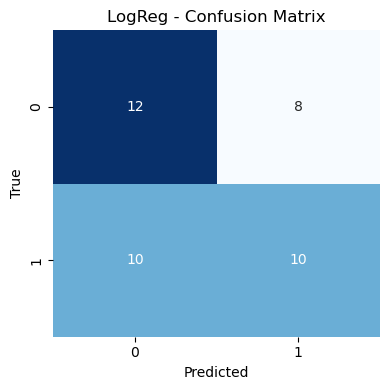

In [54]:


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("LogReg - Confusion Matrix")
plt.tight_layout(); plt.savefig(PLOTS_DIR / "logreg_confusion_matrix.png", dpi=150); plt.show()


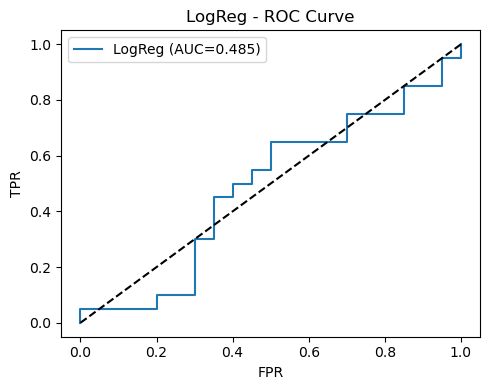

In [55]:


fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"LogReg (AUC={logreg_scores['roc']:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("LogReg - ROC Curve")
plt.legend(); plt.tight_layout(); plt.savefig(PLOTS_DIR / "logreg_roc.png", dpi=150); plt.show()


In [56]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_metrics = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    X_tr_p = preprocess.fit_transform(X_tr)
    X_va_p = preprocess.transform(X_va)

    classes = np.unique(y_tr)
    cw_vals = compute_class_weight("balanced", classes=classes, y=y_tr)
    cw_fold = {int(k): float(v) for k, v in zip(classes, cw_vals)}

    clf = LogisticRegression(max_iter=1000, class_weight=cw_fold)
    clf.fit(X_tr_p, y_tr)

    y_va_pred = clf.predict(X_va_p)
    y_va_prob = clf.predict_proba(X_va_p)[:,1]

    metrics = report_metrics(f"Fold {fold}", y_va, y_va_pred, y_va_prob)
    cv_metrics.append(metrics)



Fold 1: Acc=0.550, Prec=0.538, Rec=0.700, F1=0.609, ROC-AUC=0.485
              precision    recall  f1-score   support

           0       0.57      0.40      0.47        20
           1       0.54      0.70      0.61        20

    accuracy                           0.55        40
   macro avg       0.55      0.55      0.54        40
weighted avg       0.55      0.55      0.54        40

Fold 2: Acc=0.575, Prec=0.571, Rec=0.600, F1=0.585, ROC-AUC=0.557
              precision    recall  f1-score   support

           0       0.58      0.55      0.56        20
           1       0.57      0.60      0.59        20

    accuracy                           0.57        40
   macro avg       0.58      0.57      0.57        40
weighted avg       0.58      0.57      0.57        40

Fold 3: Acc=0.550, Prec=0.556, Rec=0.500, F1=0.526, ROC-AUC=0.532
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        20
           1       0.56      0.50      

In [57]:
# Aggregate CV
cv_df = pd.DataFrame(cv_metrics)
print("CV Mean:", cv_df.mean().to_dict())
cv_df.to_csv(ARTIFACTS_DIR / "tabular_cv_metrics.csv", index=False)


CV Mean: {'acc': 0.49000000000000005, 'prec': 0.4724053724053725, 'rec': 0.47000000000000003, 'f1': 0.46624451807239103, 'roc': 0.46699999999999997}


In [58]:
param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 3.0, 10.0],
    "logreg__penalty": ["l2"],
    "logreg__solver": ["lbfgs", "liblinear"]
}

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

gs = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV f1:", gs.best_score_)

best_pipe = gs.best_estimator_
y_pred_gs = best_pipe.predict(X_test)
y_proba_gs = best_pipe.predict_proba(X_test)[:,1]
best_scores = report_metrics("LogReg (Tuned)", y_test, y_pred_gs, y_proba_gs)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'logreg__C': 0.01, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best CV f1: 0.5668073593073593
LogReg (Tuned): Acc=0.575, Prec=0.588, Rec=0.500, F1=0.541, ROC-AUC=0.512
              precision    recall  f1-score   support

           0       0.57      0.65      0.60        20
           1       0.59      0.50      0.54        20

    accuracy                           0.57        40
   macro avg       0.58      0.57      0.57        40
weighted avg       0.58      0.57      0.57        40



In [59]:
IMG_SIZE = 128

#
lat_min = df[["cust_lat","rest_lat"]].min().min()
lat_max = df[["cust_lat","rest_lat"]].max().max()
lng_min = df[["cust_lng","rest_lng"]].min().min()
lng_max = df[["cust_lng","rest_lng"]].max().max()

def to_img_xy(lat, lng, size=IMG_SIZE):
    x = 10 + (size-20) * ((lng - lng_min) / (lng_max - lng_min + 1e-12))
    y = 10 + (size-20) * ((lat - lat_min) / (lat_max - lat_min + 1e-12))
    y = size - y
    return int(np.clip(x, 0, size-1)), int(np.clip(y, 0, size-1))

def traffic_to_thickness(t):
    m = {"Low": 1, "Medium": 2, "High": 3}
    return m.get(t, 2)

def weather_to_color(w):
   
    m = {"Sunny": 230, "Cloudy": 180, "Rainy": 130, "Snowy": 90}
    return m.get(w, 160)


In [81]:

img_rows = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    cx, cy = to_img_xy(row["cust_lat"], row["cust_lng"])
    rx, ry = to_img_xy(row["rest_lat"], row["rest_lng"])

    img = Image.new("L", (IMG_SIZE, IMG_SIZE), color=0)  
    draw = ImageDraw.Draw(img)

    thickness = traffic_to_thickness(row.get("Traffic_Conditions", "Medium"))
    color = weather_to_color(row.get("Weather_Conditions", "Cloudy"))

  

100%|██████████████████████████████████| 200/200 [00:00<00:00, 3263.67it/s]


In [82]:


from pathlib import Path
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd


In [83]:

IMG_ROOT = Path("images_data")
IMG_ROOT.mkdir(parents=True, exist_ok=True)
IMG_DIR = IMG_ROOT / "images"
IMG_DIR.mkdir(parents=True, exist_ok=True)




In [84]:

required = ["Order_ID", "cust_lat", "cust_lng", "rest_lat", "rest_lng", "y"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}. Make sure you parsed coords and created y.")



In [85]:

work = df.dropna(subset=["cust_lat","cust_lng","rest_lat","rest_lng","y"]).copy()
if work.empty:
    raise ValueError("No rows with valid coordinates and y after dropna. Check parsing and label creation.")

IMG_SIZE = 128


In [86]:


lat_min = float(min(work["cust_lat"].min(), work["rest_lat"].min()))
lat_max = float(max(work["cust_lat"].max(), work["rest_lat"].max()))
lng_min = float(min(work["cust_lng"].min(), work["rest_lng"].min()))
lng_max = float(max(work["cust_lng"].max(), work["rest_lng"].max()))


In [97]:

if np.isclose(lat_max, lat_min):
    lat_max = lat_min + 1e-6
if np.isclose(lng_max, lng_min):
    lng_max = lng_min + 1e-6

def to_img_xy(lat, lng, size=IMG_SIZE):
    
    x = 10 + (size-20) * ((lng - lng_min) / (lng_max - lng_min))
    y = 10 + (size-20) * ((lat - lat_min) / (lat_max - lat_min))
    y = size - y
    if not np.isfinite(x) or not np.isfinite(y):
        return None, None
    return int(np.clip(round(x), 0, size-1)), int(np.clip(round(y), 0, size-1))

def traffic_to_thickness(val):
    return int({"Low":1, "Medium":2, "High":3}.get(val, 2))

def weather_to_gray(val):
  
    return int(np.clip({"Sunny":230, "Cloudy":180, "Rainy":130, "Snowy":90}.get(val, 160), 0, 255))

img_rows = []
skipped = 0

for _, row in work.iterrows():
    
    cx, cy = to_img_xy(row["cust_lat"], row["cust_lng"])
    rx, ry = to_img_xy(row["rest_lat"], row["rest_lng"])
    if cx is None or cy is None or rx is None or ry is None:
        skipped += 1
        continue

   
    img = Image.new("L", (IMG_SIZE, IMG_SIZE), color=0)
    draw = ImageDraw.Draw(img)

    color = weather_to_gray(row.get("Weather_Conditions", "Cloudy"))
    thickness = traffic_to_thickness(row.get("Traffic_Conditions", "Medium"))

 
    draw.line([(int(rx), int(ry)), (int(cx), int(cy))], fill=int(color), width=int(thickness))
    draw.ellipse((int(rx)-2, int(ry)-2, int(rx)+2, int(ry)+2), fill=255)
    draw.ellipse((int(cx)-2, int(cy)-2, int(cx)+2, int(cy)+2), fill=255)

    oid = str(row["Order_ID"])
    if not oid or oid == "nan":
        skipped += 1
        continue

    fname = f"{oid}.png"
    img.save(IMG_DIR / fname)

    try:
        lbl = int(row["y"])
    except Exception:
        skipped += 1
        continue
    img_rows.append({"file": fname, "label": lbl})

In [94]:

if not img_rows:
    raise RuntimeError("No images generated. Check data, bounds, and casting.")

img_df = pd.DataFrame(img_rows)
img_df.to_csv(IMG_ROOT / "labels.csv", index=False)

print(f"Generated images: {len(img_rows)} | Skipped rows: {skipped}")
display(img_df.head())  

Generated images: 200 | Skipped rows: 0


,file,label
0,ORD0001.png,0
1,ORD0002.png,0
2,ORD0003.png,0
3,ORD0004.png,1
4,ORD0005.png,0


In [98]:
from tensorflow.keras.preprocessing import image_dataset_from_directory


FAST_DIR = IMG_ROOT / "fast"; FAST_DIR.mkdir(exist_ok=True, parents=True)
DELAY_DIR = IMG_ROOT / "delayed"; DELAY_DIR.mkdir(exist_ok=True, parents=True)


In [99]:

from shutil import copy2

for _, r in img_df.iterrows():
    src = IMG_DIR / r["file"]
    dst_dir = FAST_DIR if r["label"] == 0 else DELAY_DIR
    copy2(src, dst_dir / r["file"])


In [100]:


BATCH_SIZE = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
    IMG_ROOT,
    labels="inferred",
    label_mode="int",
    class_names=["fast","delayed"],
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    IMG_ROOT,
    labels="inferred",
    label_mode="int",
    class_names=["fast","delayed"],
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="grayscale"
)



Found 200 files belonging to 2 classes.
Using 160 files for training.
Found 200 files belonging to 2 classes.
Using 40 files for validation.


In [101]:

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)


In [102]:
def make_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 1), num_classes=1):
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(16, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss="binary_crossentropy",
                  metrics=["accuracy", keras.metrics.AUC(name="auc")])
    return model

cnn = make_cnn()
cnn.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 1)   │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ rescaling (Rescaling)         │ (None, 128, 128, 1)   │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 16)  │          160 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 16)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_1 (Conv2D)             │ (None, 64, 64, 32)    │        4,640 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_1               │ (None, 32, 32, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_2 (Conv2D)             │ (None, 32, 32, 64)    │       18,496 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ global_average_pooling2d      │ (None, 64)            │            0 │
│ (GlobalAveragePooling2D)      │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout (Dropout)             │ (None, 64)            │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                 │ (None, 1)             │           65 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 23,361 (91.25 KB)

 Trainable params: 23,361 (91.25 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:

y_counts = img_df["label"].value_counts()
total = len(img_df)
w0 = total / (2.0 * y_counts.get(0, 1))
w1 = total / (2.0 * y_counts.get(1, 1))
class_weight_cnn = {0: float(w0), 1: float(w1)}
print("CNN class weights:", class_weight_cnn)

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=MODELS_DIR / "cnn_best.keras",
                                    monitor="val_auc", mode="max",
                                    save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max",
                                  patience=5, restore_best_weights=True)
]

history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weight_cnn,
    callbacks=callbacks
)


CNN class weights: {0: 1.0, 1: 1.0}
Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.4863 - auc: 0.4953 - loss: 0.6932
Epoch 1: val_auc improved from None to 0.50000, saving model to artifacts\models\cnn_best.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 584ms/step - accuracy: 0.4938 - auc: 0.4820 - loss: 0.6932 - val_accuracy: 0.4500 - val_auc: 0.5000 - val_loss: 0.6939
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5207 - auc: 0.4813 - loss: 0.6924
Epoch 2: val_auc improved from 0.50000 to 0.52652, saving model to artifacts\models\cnn_best.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.5125 - auc: 0.4984 - loss: 0.6928 - val_accuracy: 0.4500 - val_auc: 0.5265 - val_loss: 0.6947
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5410 - auc: 0.4824 - loss: 0.6914
Epoch 3: val_auc did not improve from 0.52652
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.5125 - auc: 0.5231 - loss: 0.6920 - val_accuracy: 0.4500 - val_auc: 0.5101 - val_l

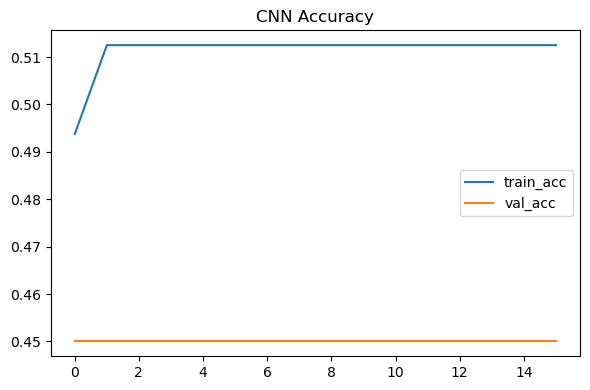

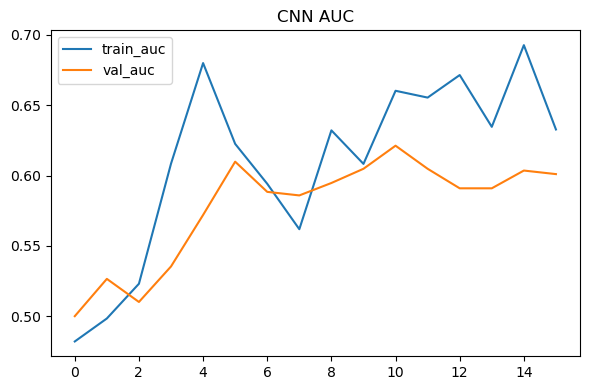

In [104]:


hist = pd.DataFrame(history.history)
hist.to_csv(ARTIFACTS_DIR / "cnn_training_history.csv", index=False)

plt.figure(figsize=(6,4))
plt.plot(hist["accuracy"], label="train_acc")
plt.plot(hist["val_accuracy"], label="val_acc")
plt.legend(); plt.title("CNN Accuracy")
plt.tight_layout(); plt.savefig(PLOTS_DIR / "cnn_accuracy.png", dpi=150); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist["auc"], label="train_auc")
plt.plot(hist["val_auc"], label="val_auc")
plt.legend(); plt.title("CNN AUC")
plt.tight_layout(); plt.savefig(PLOTS_DIR / "cnn_auc.png", dpi=150); plt.show()


In [105]:

y_true_cnn = []
y_prob_cnn = []

for imgs, labels in val_ds:
    probs = cnn.predict(imgs, verbose=0).ravel()
    y_prob_cnn.extend(probs.tolist())
    y_true_cnn.extend(labels.numpy().tolist())

y_true_cnn = np.array(y_true_cnn)
y_prob_cnn = np.array(y_prob_cnn)
y_pred_cnn = (y_prob_cnn >= 0.5).astype(int)

cnn_metrics = report_metrics("CNN (val)", y_true_cnn, y_pred_cnn, y_prob_cnn)



CNN (val): Acc=0.450, Prec=0.000, Rec=0.000, F1=0.000, ROC-AUC=0.593
              precision    recall  f1-score   support

           0       0.45      1.00      0.62        18
           1       0.00      0.00      0.00        22

    accuracy                           0.45        40
   macro avg       0.23      0.50      0.31        40
weighted avg       0.20      0.45      0.28        40



C:\Users\kunal\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kunal\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kunal\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


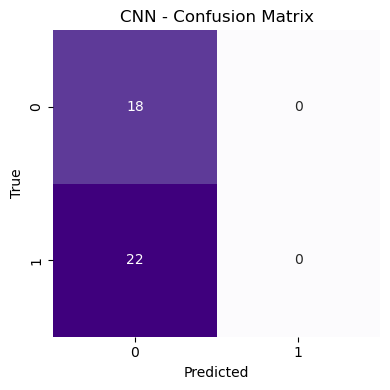

In [106]:

cm = confusion_matrix(y_true_cnn, y_pred_cnn)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Purples")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("CNN - Confusion Matrix")
plt.tight_layout(); plt.savefig(PLOTS_DIR / "cnn_confusion_matrix.png", dpi=150); plt.show()



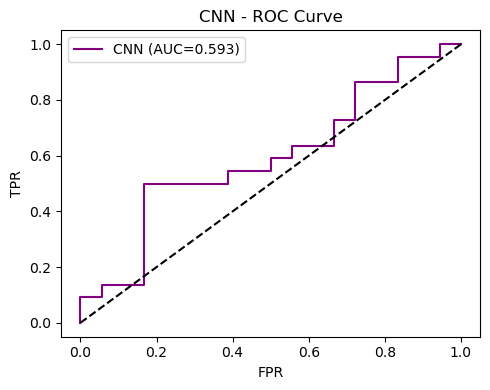

In [107]:

fpr, tpr, _ = roc_curve(y_true_cnn, y_prob_cnn)
auc_val = roc_auc_score(y_true_cnn, y_prob_cnn)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"CNN (AUC={auc_val:.3f})", color="purple")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("CNN - ROC Curve")
plt.legend(); plt.tight_layout(); plt.savefig(PLOTS_DIR / "cnn_roc.png", dpi=150); plt.show()


In [108]:
def build_cnn(filters_first=16, lr=1e-3, drop=0.3, kernel_size=3):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Rescaling(1./255)(inputs)
    f1, f2, f3 = filters_first, filters_first*2, filters_first*4

    x = layers.Conv2D(f1, kernel_size, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(f2, kernel_size, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(f3, kernel_size, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(drop)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss="binary_crossentropy",
                  metrics=["accuracy", keras.metrics.AUC(name="auc")])
    return model

search_space = [
    {"filters_first": 16, "lr": 1e-3, "drop":0.3, "kernel_size":3},
    {"filters_first": 32, "lr": 5e-4, "drop":0.4, "kernel_size":3},
    {"filters_first": 16, "lr": 1e-4, "drop":0.5, "kernel_size":5},
    {"filters_first": 32, "lr": 1e-3, "drop":0.3, "kernel_size":5},
]

best_auc = -np.inf
best_cfg = None

for cfg in search_space:
    print("Config:", cfg)
    model = build_cnn(**cfg)
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        class_weight=class_weight_cnn,
        verbose=0
    )
    val_auc = max(history.history["val_auc"])
    print("Val AUC:", val_auc)
    if val_auc > best_auc:
        best_auc = val_auc
        best_cfg = cfg
        model.save(MODELS_DIR / "cnn_tuned.keras")

print("Best CNN config:", best_cfg, "Best Val AUC:", best_auc)


Config: {'filters_first': 16, 'lr': 0.001, 'drop': 0.3, 'kernel_size': 3}
Val AUC: 0.625
Config: {'filters_first': 32, 'lr': 0.0005, 'drop': 0.4, 'kernel_size': 3}
Val AUC: 0.618686854839325
Config: {'filters_first': 16, 'lr': 0.0001, 'drop': 0.5, 'kernel_size': 5}
Val AUC: 0.6527777910232544
Config: {'filters_first': 32, 'lr': 0.001, 'drop': 0.3, 'kernel_size': 5}
Val AUC: 0.622474730014801
Best CNN config: {'filters_first': 16, 'lr': 0.0001, 'drop': 0.5, 'kernel_size': 5} Best Val AUC: 0.6527777910232544


In [109]:
comparison = pd.DataFrame([
    {"model":"LogReg (default)", **logreg_scores},
    {"model":"LogReg (tuned)", **best_scores},
    {"model":"CNN (val)", **cnn_metrics}
])
comparison


,model,acc,prec,rec,f1,roc
0,LogReg (default),0.550,0.555556,0.5,0.526316,0.485000
1,LogReg (tuned),0.575,0.588235,0.5,0.540541,0.512500
2,CNN (val),0.450,0.000000,0.0,0.000000,0.593434


In [110]:
import joblib
joblib.dump(preprocess, MODELS_DIR / "preprocess.joblib")
joblib.dump(logreg, MODELS_DIR / "logreg_default.joblib")
joblib.dump(best_pipe, MODELS_DIR / "logreg_tuned.joblib")
print("Saved tabular models and preprocessors.")


Saved tabular models and preprocessors.
